In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras as keras
from keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam

2024-07-10 09:57:13.478563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 09:57:13.478612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 09:57:13.479174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 09:57:13.482632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 09:57:14.047418: W tensorflow/compiler/tf2

**Creating the test and train dataset**

In [2]:
path_to_data = './Bone Break Classification'

In [3]:
train_data=utils.image_dataset_from_directory(
    path_to_data,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40,
)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.


2024-07-10 09:57:14.951376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-10 09:57:14.951641: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
val_data=utils.image_dataset_from_directory(
    path_to_data,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40,
)

Found 1129 files belonging to 10 classes.
Using 112 files for validation.


In [5]:
for images,lables in train_data.take(1):
  print('Amount of train images: ', images.shape)
  print('Amount of train labels: ', lables.shape)

Amount of train images:  (64, 256, 256, 3)
Amount of train labels:  (64,)


In [6]:
for images,lables in val_data.take(1):
  print('Amount of validation images: ', images.shape)
  print('Amount of validation labels: ', lables.shape)

Amount of validation images:  (64, 256, 256, 3)
Amount of validation labels:  (64,)


**Pre-Processing**

In [7]:
classes=train_data.class_names
print('The following classes are in the dataset:')
print(classes)

The following classes are in the dataset:
['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [8]:
def normalize(image, label):
  return image/255.0, label

In [9]:
train_data = train_data.map(normalize)
val_data= val_data.map(normalize)

**Test and Train**

In [10]:
train_x=[]
train_y=[]

for image,label in train_data:
   train_x.append(image)
   train_y.append(label)

train_x = tf.concat(train_x, axis=0)
train_y = tf.concat(train_y, axis=0)

2024-07-10 09:57:15.688438: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 799801344 exceeds 10% of free system memory.


In [11]:
train_x

<tf.Tensor: shape=(1017, 256, 256, 3), dtype=float32, numpy=
array([[[[4.24509794e-01, 4.24509794e-01, 4.24509794e-01],
         [4.26124007e-01, 4.26124007e-01, 4.26124007e-01],
         [4.32314634e-01, 4.32314634e-01, 4.32314634e-01],
         ...,
         [4.47549015e-01, 4.47549015e-01, 4.47549015e-01],
         [5.02726734e-01, 5.02726734e-01, 5.02726734e-01],
         [4.94117647e-01, 4.94117647e-01, 4.94117647e-01]],

        [[4.27450985e-01, 4.27450985e-01, 4.27450985e-01],
         [4.29603249e-01, 4.29603249e-01, 4.29603249e-01],
         [4.37452137e-01, 4.37452137e-01, 4.37452137e-01],
         ...,
         [4.47549015e-01, 4.47549015e-01, 4.47549015e-01],
         [5.02726734e-01, 5.02726734e-01, 5.02726734e-01],
         [4.94117647e-01, 4.94117647e-01, 4.94117647e-01]],

        [[4.27450985e-01, 4.27450985e-01, 4.27450985e-01],
         [4.29603249e-01, 4.29603249e-01, 4.29603249e-01],
         [4.39883947e-01, 4.39883947e-01, 4.39883947e-01],
         ...,
        

In [12]:
val_x=[]
val_y=[]

for image,label in train_data:
   val_x.append(image)
   val_y.append(label)

val_x = tf.concat(val_x, axis=0)
val_y = tf.concat(val_y, axis=0)

2024-07-10 09:57:16.149590: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 799801344 exceeds 10% of free system memory.


**One Hot Encoding for categorical data**

In [13]:
num_classes = 10
train_y = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)
val_y = tf.keras.utils.to_categorical(val_y, num_classes=num_classes)

**Take a look at the data**

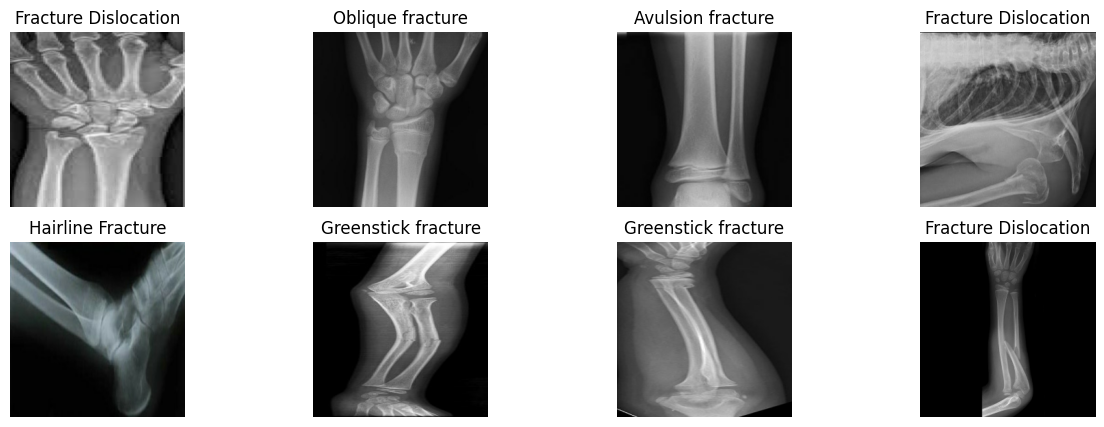

In [14]:
class_labels=["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",
              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",
              "Pathological fracture","Spiral Fracture"]

fig, axes = plt.subplots(2, 4, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    image, label = train_x[i], train_y[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"{class_labels[np.argmax(label)]}")
    ax.axis('off')
    
plt.show()

**Convolutional Neural Network**

In [15]:
model = Sequential()
model.add(Conv2D(60, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(120, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 60)      1680      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 60)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 120)     64920     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 120)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 461280)            0         
                                                                 
 dense (Dense)               (None, 40)                1

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Training the model**

In [18]:
model.fit(train_x, train_y, batch_size=10, epochs=5,
          validation_data=(val_x,val_y))

Epoch 1/5
102/102 [==============================] - 54s 525ms/step - loss: 2.5209 - accuracy: 0.1170 - val_loss: 2.2501 - val_accuracy: 0.1544
Epoch 2/5
102/102 [==============================] - 53s 517ms/step - loss: 2.2535 - accuracy: 0.1947 - val_loss: 2.0005 - val_accuracy: 0.3245
Epoch 3/5
102/102 [==============================] - 53s 518ms/step - loss: 1.8560 - accuracy: 0.3756 - val_loss: 1.2923 - val_accuracy: 0.6834
Epoch 4/5
102/102 [==============================] - 53s 525ms/step - loss: 1.1195 - accuracy: 0.6549 - val_loss: 0.7987 - val_accuracy: 0.8289
Epoch 5/5
102/102 [==============================] - 54s 525ms/step - loss: 0.6063 - accuracy: 0.8466 - val_loss: 0.2391 - val_accuracy: 0.9567


In [19]:
loss, accuracy = model.evaluate(val_x,val_y)
print('Test accuracy:', accuracy)

32/32 [==============================] - 7s 231ms/step - loss: 0.2391 - accuracy: 0.9567
Test accuracy: 0.9567354917526245


In [20]:
pred = model.predict(val_x)
print(pred)

32/32 [==============================] - 8s 237ms/step
[[1.6014291e-04 2.7570684e-07 2.8810443e-06 ... 9.9605745e-07
  5.5395784e-08 9.7841519e-01]
 [1.0067273e-02 2.1290462e-02 6.6703266e-01 ... 1.4046091e-02
  2.0705236e-02 7.3477225e-03]
 [2.8725584e-05 7.3916541e-05 1.2709411e-04 ... 1.0235065e-06
  6.9890535e-05 3.1246813e-07]
 ...
 [1.1470405e-04 6.4871574e-06 6.1337429e-04 ... 1.3537816e-03
  9.9407828e-01 9.7157829e-07]
 [1.0400931e-01 3.8549289e-02 1.0497142e-02 ... 3.7809085e-02
  1.4299323e-02 5.8114836e-03]
 [4.1055566e-04 1.0315119e-04 9.9884939e-01 ... 4.3798607e-08
  2.6860380e-06 1.0049907e-05]]


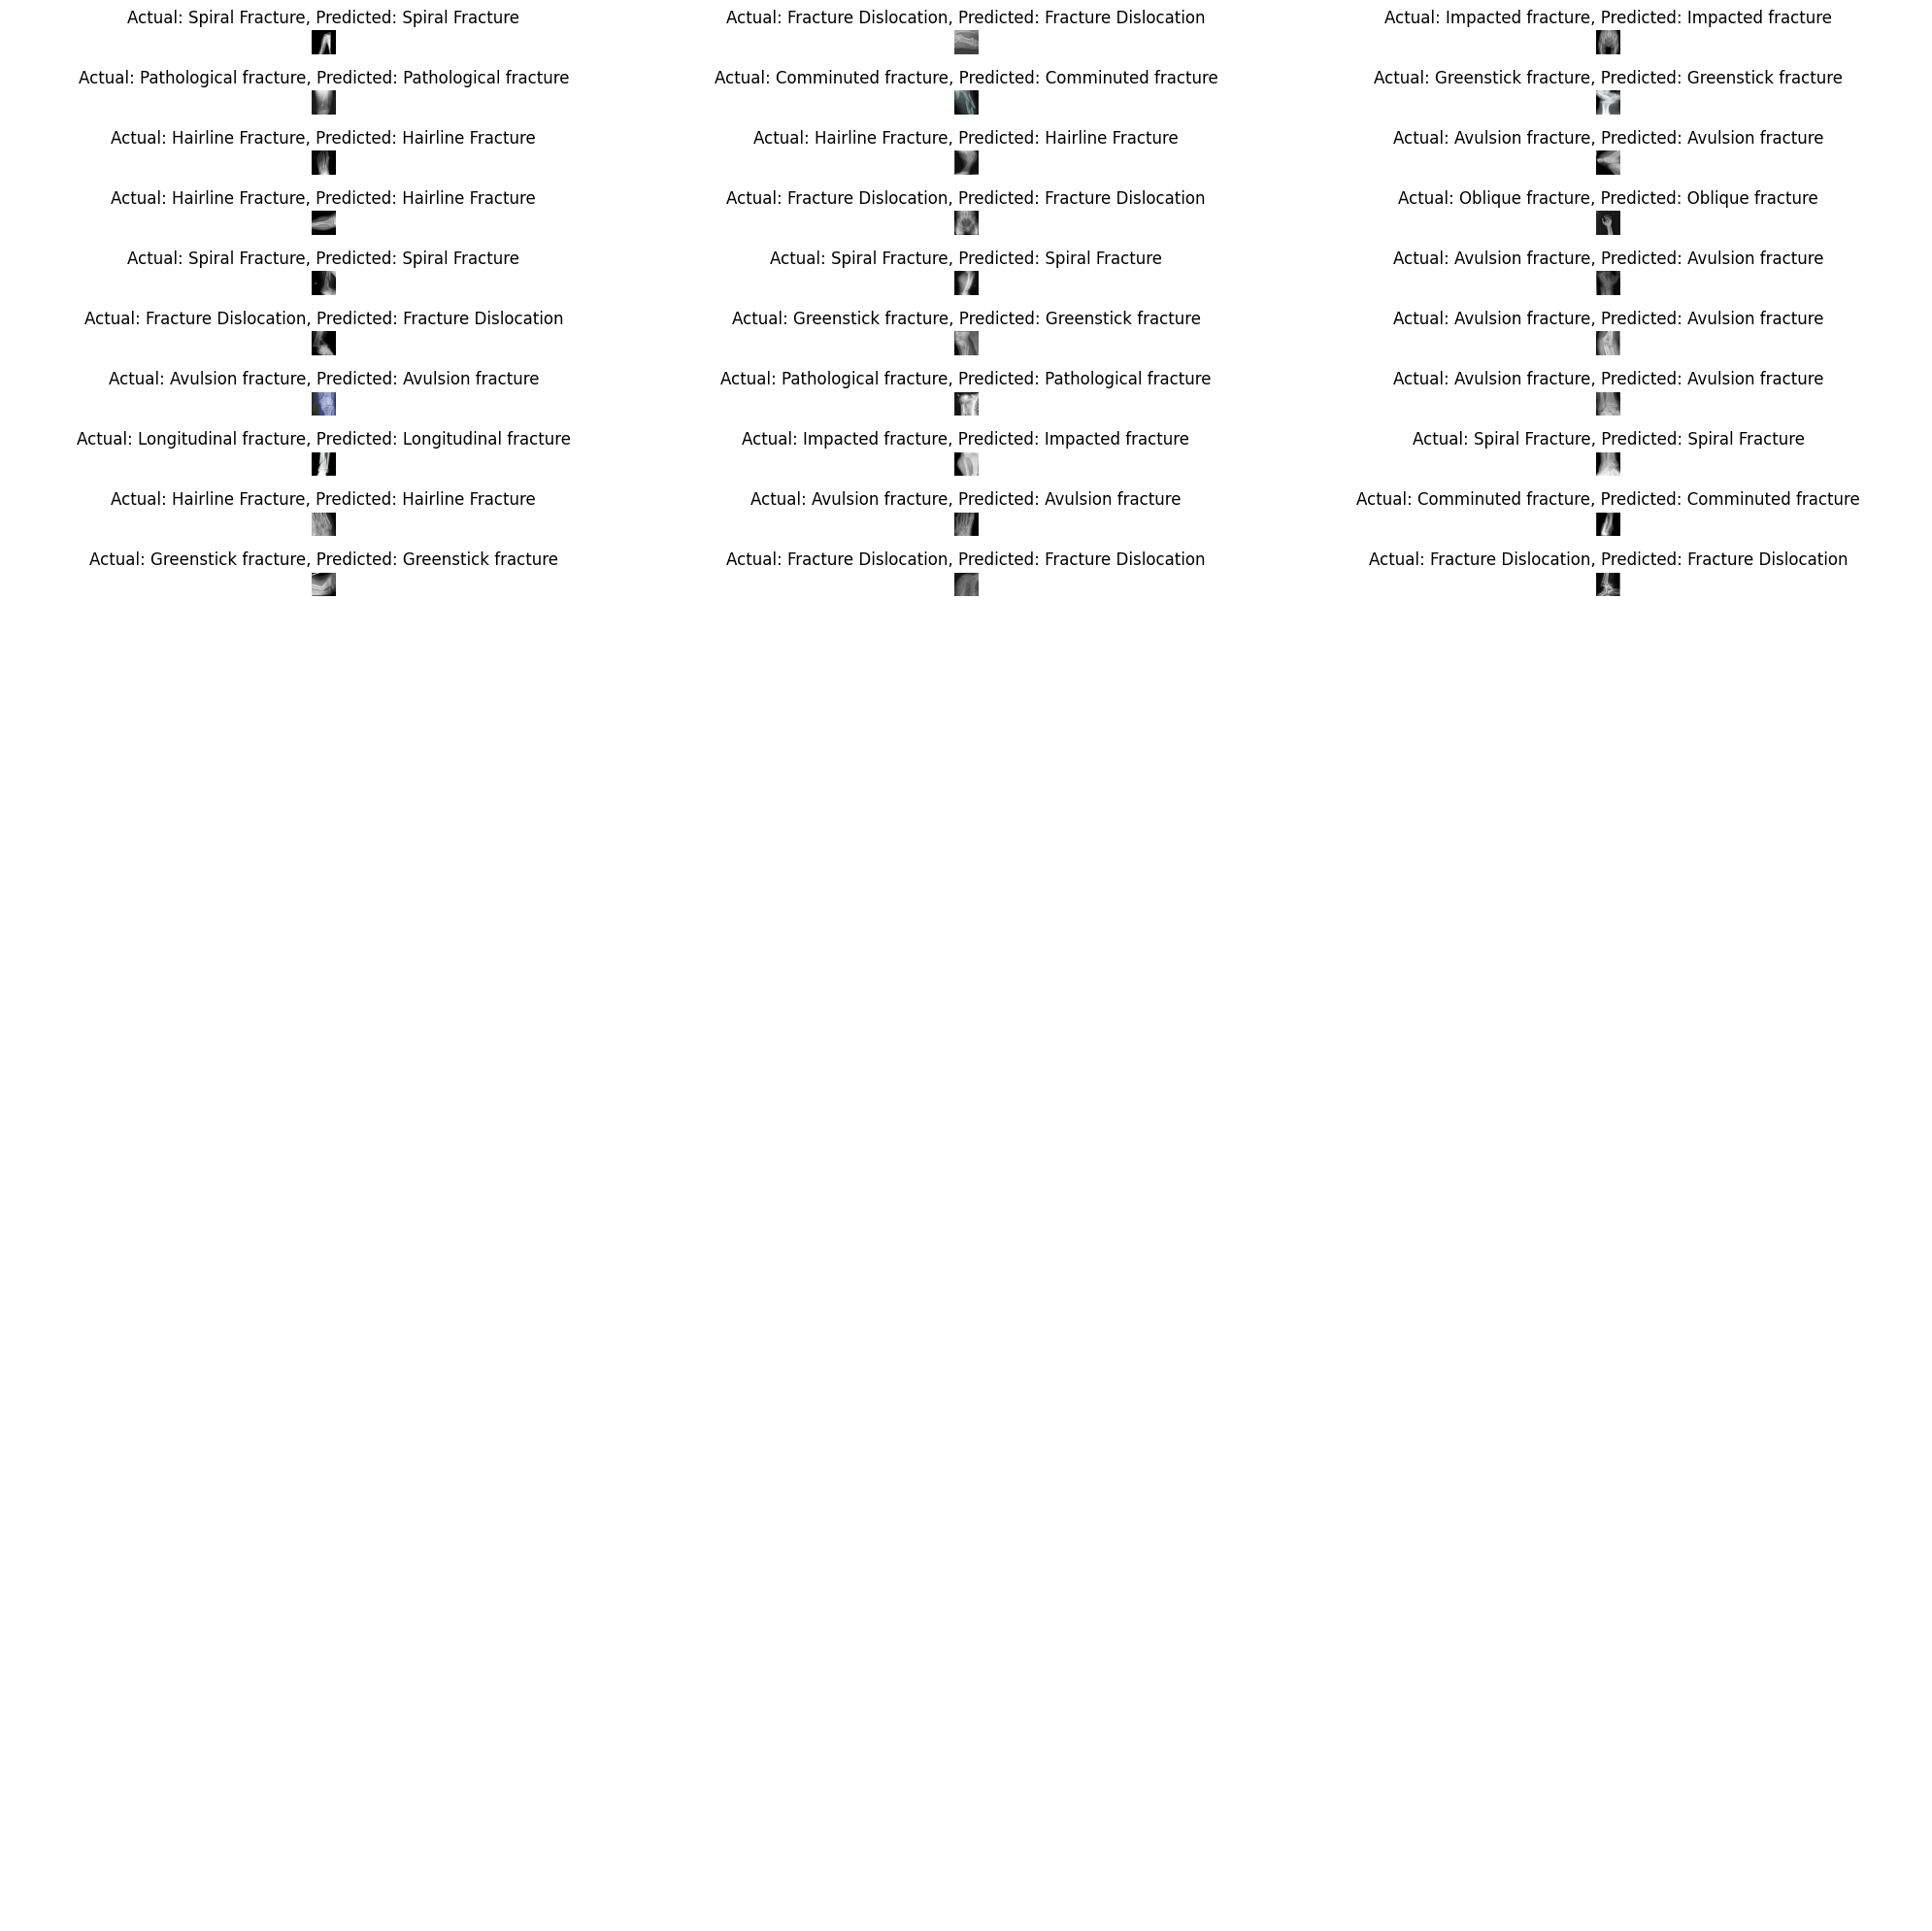

In [21]:
num_images_to_display = 30
num_columns = 3
num_rows = (num_images_to_display + num_columns - 1) 

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    if i < num_images_to_display:
        ax.imshow(val_x[i])
        actual_label = class_labels[np.argmax(val_y[i])]
        predicted_label = class_labels[np.argmax(pred[i])]
        ax.set_title(f"Actual: {actual_label}, Predicted: {predicted_label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [34]:
from tensorflow.keras.preprocessing import image

img = image.load_img('spiral.png', target_size=(256,256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

In [38]:
pred = model.predict(img_array)
predicted_label = class_labels[np.argmax(pred[0])]
print(predicted_label)

1/1 [==============================] - 0s 20ms/step
Spiral Fracture
